In [39]:
from LOTlib3.Grammar import Grammar
from math import log
from LOTlib3.Hypotheses.LOTHypothesis import LOTHypothesis
from LOTlib3.DataAndObjects import FunctionData
from LOTlib3.TopN import TopN
from LOTlib3.Samplers.MetropolisHastings import MetropolisHastingsSampler
from LOTlib3.Eval import primitive

In [150]:
import numpy as np
import pandas as pd

import os
import json
import time
import copy

from IPython.display import clear_output
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors

from PIL import Image, ImageDraw
from IPython.display import Image as Im
from itertools import permutations, combinations
from sympy.utilities.iterables import multiset_permutations

# from skimage.segmentation import flood, flood_fill

%matplotlib inline

In [192]:
# define solver
class ARCSolver:
    def __init__(self, task_filename):
        # load task and extract input and output pairs
        self.task_filename = task_filename
        self.task = self.load_task(task_filename)
        self.train_inputs, self.train_outputs, self.test_inputs, self.test_outputs = \
            self.extract_io_pairs()
        self.test_pred = np.zeros((5, 5))
        self.test_pred_height, self.test_pred_width = self.test_pred.shape
        
        self.solved = False  # have we solved the task yet?
        self.selected_colour = 0
        self.clipboard = None
        self.description = ''
        
        # variables for plotting
        self.cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
        self.colour_to_num = {'black': 0, 'blue': 1, 'red': 2, 'green': 3, 'yellow': 4,
                             'grey': 5, 'magenta': 6, 'orange': 7, 'light_blue': 8, 
                             'maroon': 9}
        self.num_to_colour = {0: 'black', 1: 'blue', 2: 'red', 3: 'green', 4: 'yellow',
                             5: 'grey', 6: 'magneta', 7: 'orange', 8: 'light_blue',
                             9: 'maroon'}

        
    def load_task(self, task_filename):
        with open(task_filename, 'r') as f:
            task = json.load(f)    
        return task

    def plot_task(self):
        """
        Plots the first train and test pairs of a specified task,
        using same color scheme as the ARC app
        """
        norm = colors.Normalize(vmin=0, vmax=9)
        n_train = len(self.task['train'])
        fig, axs = plt.subplots(n_train+1, 2, figsize=(10, 10))
        for i in range(n_train):
            axs[i, 0].imshow(self.task['train'][i]['input'], cmap=self.cmap, norm=norm)
            axs[i, 0].axis('off')
            axs[i, 0].set_title('Train Input')
            axs[i, 1].imshow(self.task['train'][i]['output'], cmap=self.cmap, norm=norm)
            axs[i, 1].axis('off')
            axs[i, 1].set_title('Train Output')
        axs[n_train, 0].imshow(self.task['test'][0]['input'], cmap=self.cmap, norm=norm)
        axs[n_train, 0].axis('off')
        axs[n_train, 0].set_title('Test Input')
        axs[n_train, 1].imshow(self.task['test'][0]['output'], cmap=self.cmap, norm=norm)
        axs[n_train, 1].axis('off')
        axs[n_train, 1].set_title('Test Output')
        plt.tight_layout()
        plt.show()
    
    def plot_grid(self, grid):
        """
        Plots a single grid
        """
        #plt.clf()

        #plt.draw()
        #display(plt)
        

    def plot_grids(self, grids):
        """
        Plots a list of grids
        """
        n_grids = len(grids)
        norm = colors.Normalize(vmin=0, vmax=9)
        fig, axs = plt.subplots(1, n_grids, figsize=(6, 6), squeeze=False)
        for i in range(n_grids):
            axs[0, i].imshow(grids[i], cmap=self.cmap, norm=norm)
            axs[0, i].axis('off')
        plt.tight_layout()
        plt.show()
    
    def extract_io_pairs(self):
        train = self.task['train']
        test = self.task['test']
        n_train = len(train)
        n_test = len(test)

        train_inputs = [train[i]['input'] for i in range(n_train)]
        train_inputs = [np.asarray(i) for i in train_inputs]
        train_outputs = [train[i]['output'] for i in range(n_train)]
        train_outputs = [np.asarray(i) for i in train_outputs]
        test_inputs = [test[i]['input'] for i in range(n_test)]
        test_inputs = [np.asarray(i) for i in test_inputs]
        test_outputs = [test[i]['output'] for i in range(n_test)]
        test_outputs = [np.asarray(i) for i in test_outputs]

        return train_inputs, train_outputs, test_inputs, test_outputs
    

In [144]:
colorMap = {0:"black",1:"blue",2:"red", 3:"green",4:"yellow",5:"grey",6:"magenta",7:"orange",8:"cyan",9:"brown"}

In [3]:
# intializing basic hypothesis, will edit later
class ARCHypothesis(LOTHypothesis):
    def __init__(self, **kwargs):
        LOTHypothesis.__init__(self, grammar=grammar, display="lambda grid: %s", **kwargs)
        
    def __call__(self, *args):
        try:
            # try to do it from the superclass
            return LOTHypothesis.__call__(self, *args)
        except ZeroDivisionError:
            # and if we get an error, return nan
            return float("nan")

    def compute_single_likelihood(self, datum):
        # for each correct pixel, add log(1), for each incorrect, add log(exp(-b))
        ll = 0
        input_grid = self(*datum.input)
        output_grid = datum.output
        # assuming input and output are the same size for now
        height, width = len(input_grid[:,0]), len(input_grid[0,:])
        for i in range(height):
            for j in range(width):
                if input_grid[i][j] == output_grid[i][j]:
                    ll += log(1)
#                 elif input_grid[i][j] == 0 and output_grid[i][j] != 0:
#                     ll += log(0.1)
                else:
                    ll += log(0.05)
        # print(self.value, ll)
        return ll
        
    def display_hypothesis(self):
        return self.value

In [269]:
# initializing grammar
grammar = Grammar(start='GRID')

# Boolean
grammar.add_rule('BOOLEAN', True, None, 1.0)
grammar.add_rule('BOOLEAN', False, None, 1.0)
grammar.add_rule('BOOLEAN', 'not %s', ['BOOLEAN'], 1.0)
grammar.add_rule('BOOLEAN', '%s or %s', ['BOOLEAN', 'BOOLEAN'], 1.0)
grammar.add_rule('BOOLEAN', '%s and %s', ['BOOLEAN', 'BOOLEAN'], 1.0)
grammar.add_rule('BOOLEAN', 'equals_object', ['OBJECT', 'OBJECT'], 1.0)
grammar.add_rule('BOOLEAN', 'equals_location', ['LOC', 'LOC'], 1.0)
grammar.add_rule('BOOLEAN', 'equals_color', ['COLOR', 'COLOR'], 1.0)
grammar.add_rule('BOOLEAN', 'equals_int', ['INT', 'INT'], 1.0)
grammar.add_rule('BOOLEAN', '%s > %s', ['INT', 'INT'], 1.0)
grammar.add_rule('BOOLEAN', '%s < %s', ['INT', 'INT'], 1.0)
# grammar.add_rule('BOOLEAN', 'is_touching', ['OBJECT', 'OBJECT'], 1.0)
# grammar.add_rule('BOOLEAN', 'has_color', ['OBJECT', 'COLOR'], 1.0)
# grammar.add_rule('BOOLEAN', 'is_color', ['LOC', 'COLOR'], 1.0)
# grammar.add_rule('BOOLEAN', 'is_size', ['OBJECT', 'INT'], 1.0)

# Integer
for n in range(10):
    grammar.add_rule('INT', n, None, 1.0)
grammar.add_rule('INT', 'object_height', ['OBJECT'], 1.0)
grammar.add_rule('INT', 'object_width', ['OBJECT'], 1.0)
grammar.add_rule('INT', 'num_objects', ['GRID'], 100.0)
grammar.add_rule('INT', 'num_grid_colors', ['GRID'], 1.0)
grammar.add_rule('INT', 'num_colors', ['OBJECT'], 1.0)
grammar.add_rule('INT', 'grid_height', ['GRID'], 1.0)
grammar.add_rule('INT', 'grid_width', ['GRID'], 1.0)


# Colors
for n in range(10):
    grammar.add_rule('COLOR', str(n), None, 1.0)
grammar.add_rule('COLOR', 'object_color', ['OBJECT'], 1.0)
grammar.add_rule('COLOR', 'background_color', ['GRID'], 1.0)
grammar.add_rule('COLOR', 'get_color', ['GRID','LOC'], 1.0)

# Location
for i in range(30):
    for j in range(30):
        grammar.add_rule('LOC', [i,j], None, 1.0)
grammar.add_rule('LOC', 'top_left', ['OBJECT'],1.0)
grammar.add_rule('LOC', 'top_right', ['OBJECT'],1.0)
grammar.add_rule('LOC', 'bottom_left', ['OBJECT'],1.0)
grammar.add_rule('LOC', 'bottom_right', ['OBJECT'],1.0)
grammar.add_rule('LOC', 'top_left_corner', ['GRID'],1.0)
grammar.add_rule('LOC', 'top_right_corner', ['GRID'],1.0)
grammar.add_rule('LOC', 'bottom_left_corner', ['GRID'],1.0)
grammar.add_rule('LOC', 'bottom_right_corner', ['GRID'],1.0)

# Dictionary

# List/Set

# SetB
# SetC
# AllColors(Grid)
# SetL
# SetO

# Objects
grammar.add_rule('OBJECT', 'object_by_color', ['GRID', 'COLOR'], 1.0)


# Grid
grammar.add_rule('GRID', 'grid', None, 5.0)
# grammar.add_rule('GRID', 'color_grid', ['GRID','COLOR'], 1.0)
grammar.add_rule('GRID', 'reflection_horizontal', ['GRID'], 1.0)
grammar.add_rule('GRID', 'reflection_vertical', ['GRID'], 1.0)
grammar.add_rule('GRID', 'rotation_90', ['GRID'], 1.0)
grammar.add_rule('GRID', 'rotation_180', ['GRID'], 1.0)
grammar.add_rule('GRID', 'rotation_270', ['GRID'], 1.0)
# grammar.add_rule('GRID', 'scale', ['GRID', 'INT'], 1.0)
# grammar.add_rule('GRID', 'repeat', ['GRID'], 1.0)
grammar.add_rule('GRID', 'gravity', ['GRID'], 1.0)
# grammar.add_rule('GRID', 'replace', ['OBJECT','OBJECT','GRID'], 1.0)
grammar.add_rule('GRID', 'logic_and', ['GRID','GRID'], 1.0)
grammar.add_rule('GRID', 'logic_or', ['GRID','GRID'], 1.0)
grammar.add_rule('GRID', 'logic_xor', ['GRID','GRID'], 1.0)
grammar.add_rule('GRID', 'move_object_vertical', ['GRID', 'OBJECT', 'INT'], 1.0)
grammar.add_rule('GRID', 'move_object_horizontal', ['GRID', 'OBJECT', 'INT'], 1.0)
# extend color
# connect color


GRID -> move_object_horizontal['GRID', 'OBJECT', 'INT']	w/ p=1.0

In [274]:
### Object Primitives ###
@primitive
def object_by_color(grid, color):
    obj = []
    coords = list(zip(np.where(grid==color)[0],np.where(grid==color)[1]))
    for coord in coords:
        obj.append([coord[0],coord[1],color])
    return obj

### Boolean Primitives ###
@primitive
def equals_object(obj1,obj2):
    return sorted(relative_positions(obj1)) == sorted(relative_positions(obj2))
        
@primitive
def equals_location(loc1,loc2):
    if loc1[0] == loc2[0] and loc1[1] == loc2[1]:
        return True
    return False
    
@primitive
def equals_color(col1,col2):
    if col1 == col2:
        return True
    return False

@primitive
def equals_int(int1,int2):
    if int1==int2:
        return True
    return False

### Integer Primitives ###
@primitive
def object_height(obj):
    return max(obj, key=lambda x: x[0])[0] - min(obj, key=lambda x: x[0])[0]

@primitive
def object_width(obj):
    return max(obj, key=lambda x: x[1])[1] - min(obj, key=lambda x: x[1])[1]

@primitive
def grid_height(grid):
    return len(grid[:,0])

@primitive
def grid_width(grid):
    return len(grid[0,:])

@primitive
def num_objects(grid):
    # for now just using objects by color, and assuming black is background
    obj_counter = 0
    for i in range(1,10):
        if object_by_color(grid,i) != []:
            obj_counter += 1
    return obj_counter

@primitive
def num_grid_colors(grid):
    # assuming there's always a background color
    return len(np.unique(grid)) - 1

@primitive
def num_colors(obj):
    return len(np.unique(obj))

### Color Primitives ###
@primitive
def object_color(obj):
    # return the color that appears the most times in the object
    clrs, counts = np.unique(obj[:,2], return_counts=True)
    return clrs[np.argmax(counts)]

@primitive
def background_color(grid):
    # return the color that appears the most times in the grid
    clrs, counts = np.unique(grid, return_counts=True)
    return clrs[np.argmax(counts)]

@primitive
def get_color(grid,loc):
    return grid[loc[0]][loc[1]]

### Location Primitives ###
@primitive
def top_left(obj):
    sorted_obj = sorted(obj, key=lambda x: x[0])
    return sorted_obj[0][:2]

@primitive
def top_right(obj):
    sorted_obj = sorted(obj, key=lambda x: x[1], reverse=True)
    sorted_obj = sorted(sorted_obj, key=lambda x: x[0])
    return sorted_obj[0][:2]

@primitive
def bottom_left(obj):
    sorted_obj = sorted(obj, key=lambda x: x[1])
    sorted_obj = sorted(sorted_obj, key=lambda x: x[0], reverse=True)
    return sorted_obj[0][:2]

@primitive
def bottom_right(obj):
    sorted_obj = sorted(obj, key=lambda x: x[0], reverse=True)
    sorted_obj = sorted(sorted_obj, key=lambda x: x[1], reverse=True)
    return sorted_obj[0][:2]

@primitive
def top_left_corner(grid):
    return [0,0]

@primitive 
def top_right_corner(grid):
    return [0,grid_width(grid)]

@primitive
def bottom_left_corner(grid):
    return [grid_height(grid),0]

@primitive
def bottom_right_corner(grid):
    return [grid_height(grid),grid_width(grid)]


# Grid primitives
@primitive
def color_grid(grid, color):
    for i in range(grid_height(grid)):
        for j in range(grid_width(grid)):
            grid[i][j] = color
    return grid

@primitive
def reflection_vertical(grid):
    return np.flipud(grid)

@primitive
def reflection_horizontal(grid):
    return np.fliplr(grid)

@primitive
def rotation_90(grid):
    return np.rot90(grid,1)

@primitive
def rotation_180(grid):
    return np.rot90(grid,2)

@primitive
def rotation_270(grid):
    return np.rot90(grid,3)

@primitive
def gravity(grid):
    background_col = background_color(grid)
    grid_copy = copy.deepcopy(grid)
    grid_copy = color_grid(grid_copy, background_col)
    for i in range(grid_width(grid)):
        col = grid[:,i]
        grav = col[col!=background_col]
        for k in range(1,len(grav)+1):
            grid_copy[-k,i] = grav[-k]
    return grid_copy

@primitive
def logic_and(grid1,grid2):
    # assuming background is black for now
    # if they're not the same size, arbitrarily return the first
    if grid_height(grid1) != grid_height(grid2) or grid_width(grid1) != grid_width(grid2):
        return grid1
    else:
        return np.logical_and(grid1,grid2)
    
@primitive
def logic_or(grid1,grid2):
    # assuming background is black for now
    # if they're not the same size, arbitrarily return the first
    if grid_height(grid1) != grid_height(grid2) or grid_width(grid1) != grid_width(grid2):
        return grid1
    else:
        return np.logical_or(grid1,grid2)
    
@primitive
def logic_xor(grid1,grid2):
    # assuming background is black for now
    # if they're not the same size, arbitrarily return the first
    if grid_height(grid1) != grid_height(grid2) or grid_width(grid1) != grid_width(grid2):
        return grid1
    else:
        return np.logical_xor(grid1,grid2)
    
# @primitive
# def replace(obj1,obj2,grid):
#     # repace obj1 by obj2
#     back_col = background_color(grid)
#     h1,w1 = object_height(obj1), object_width(obj1)
#     h2,w2 = object_height(obj2), object_width(obj2)
#     if h1 != h2 or w1 != w2:
#         return grid
#     else:
#         obj2_copy = np.ones((h2,w2))*back_col
#         obj2_rel_pos = relative_positions(obj2)
#         for pos in obj2_rel_pos:
#             obj2_copy[pos[0]][pos[1]] = pos[2]

@primitive
def move_object_vertical(grid, obj, int_):
    h,w = grid_height(grid), grid_width(grid)
    grid_copy = copy.deepcopy(grid)
    back_col = background_color(grid)
    for coord in obj:
        dy = coord[0]+int_
        if dy > h or dy < 0:
            return grid
        grid_copy[coord[0]][coord[1]]= back_col
        grid_copy[dy][coord[1]] = coord[2]
    return grid_copy

@primitive
def move_object_horizontal(grid, obj, int_):
    h,w = grid_height(grid), grid_width(grid)
    grid_copy = copy.deepcopy(grid)
    back_col =  background_color(grid)
    for coord in obj:
        dx = coord[1]+int_
        if dx > w or dx < 0:
            return grid
        grid_copy[coord[0]][coord[1]]= back_col
        grid_copy[coord[0]][dx] = coord[2]
    return grid_copy
    

# Helper functions
def relative_positions(obj):
    dx, dy = top_left(obj)[0], top_left(obj)[1]
    rel_obj = []
    for coord in obj:
        rel_obj.append([coord[0]-dx,coord[1]-dy, coord[2]])
    return rel_obj

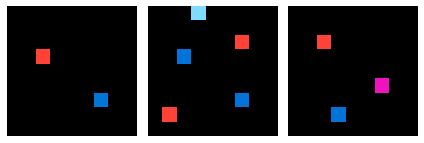

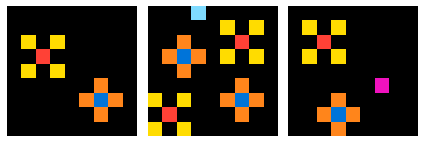

In [275]:
training_path = "/Users/aysjajohnson/Desktop/ARC-master/data/training/"
solver = ARCSolver(task_filename=os.path.join(training_path, '0ca9ddb6.json'))
# solver = ARCSolver(task_filename=os.path.join(training_path, '0a938d79.json'))
solver.plot_grids(solver.train_inputs)
solver.plot_grids(solver.train_outputs)

In [276]:
inputs = solver.train_inputs
outputs = solver.train_outputs
grid1 = inputs[0]
grid2 = outputs[0]
grid3 = outputs[1]

In [278]:
h0 = ARCHypothesis()

In [282]:
for i in range(10):
    h0 = ARCHypothesis()
    print(h0)
    print(h0(grid1))

lambda grid: logic_and(rotation_270(grid), reflection_horizontal(grid))
[[False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False  True False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]]
lambda grid: grid
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
lambda grid: rotation_180(reflection_vertical(logic_xor(reflection_vertical(logic_and(grid, reflection_horizontal(logic_xor(rotation_270(grid), rotation_180(rotation_270(logic_xor(logic_xor(rotation_90(grid

AssertionError: 

In [57]:
h0(grid1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])